In [1]:
import os
import random
import sys
sys.path.append("../src")

import cv2
import torch
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from defs import ROOT, VAL_DATA_PATH, VAL_IMAGES_PATH, VAL_MASKS_PATH
from dt2.register import register_my_dataset
from dt2.visualize import visualize_dataset_dict, visualize_batch_item
from inference.predictor import get_predictor
from train_dt2 import Trainer

In [2]:
dataset_name = "val-dataset"
metadata = MetadataCatalog.get(dataset_name)
register_my_dataset(dataset_name, {}, VAL_IMAGES_PATH, VAL_IMAGES_PATH, VAL_MASKS_PATH, VAL_DATA_PATH / "coco.json")

In [3]:
exp_name = "panopticFPN-resnet50"
exp_dir = ROOT / "outputs" / exp_name
score_thresh = 0.05
nms_thresh = 0.5
predictor = get_predictor(exp_dir, score_thresh, nms_thresh, tta=True)

PANOPTIC_FPN.COMBINED.ENABLED is no longer used.  model.inference(do_postprocess=) should be used to toggle postprocessing.


In [4]:
dataset_dicts = DatasetCatalog.get(dataset_name)

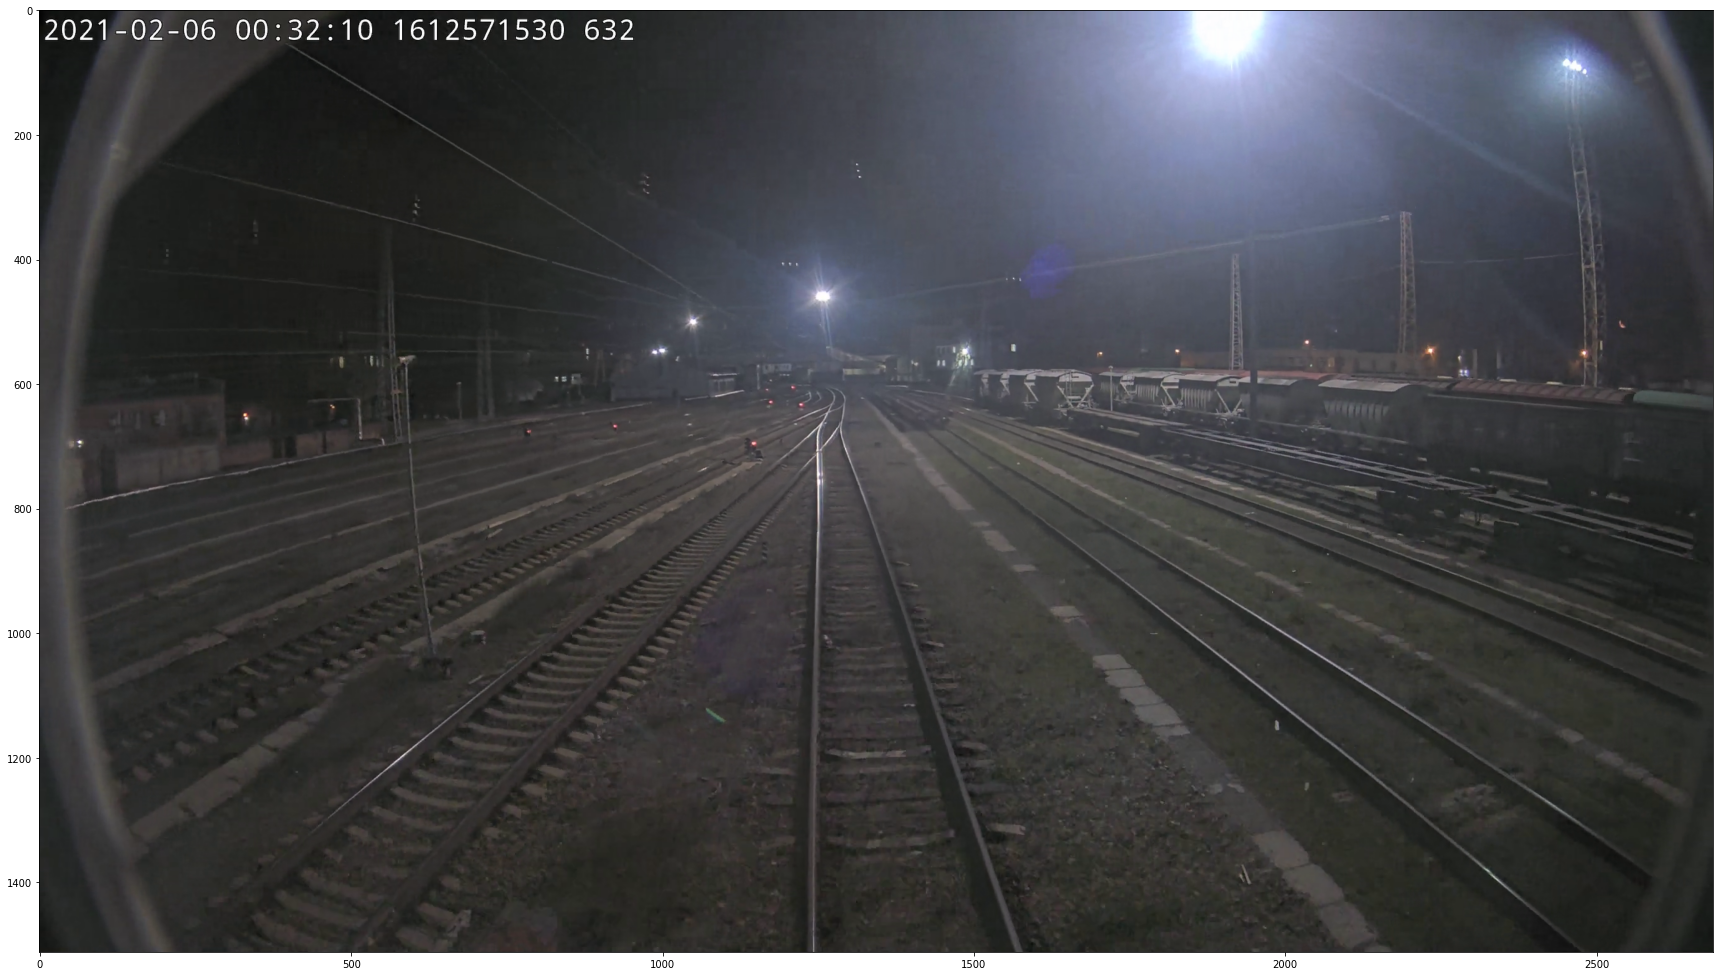

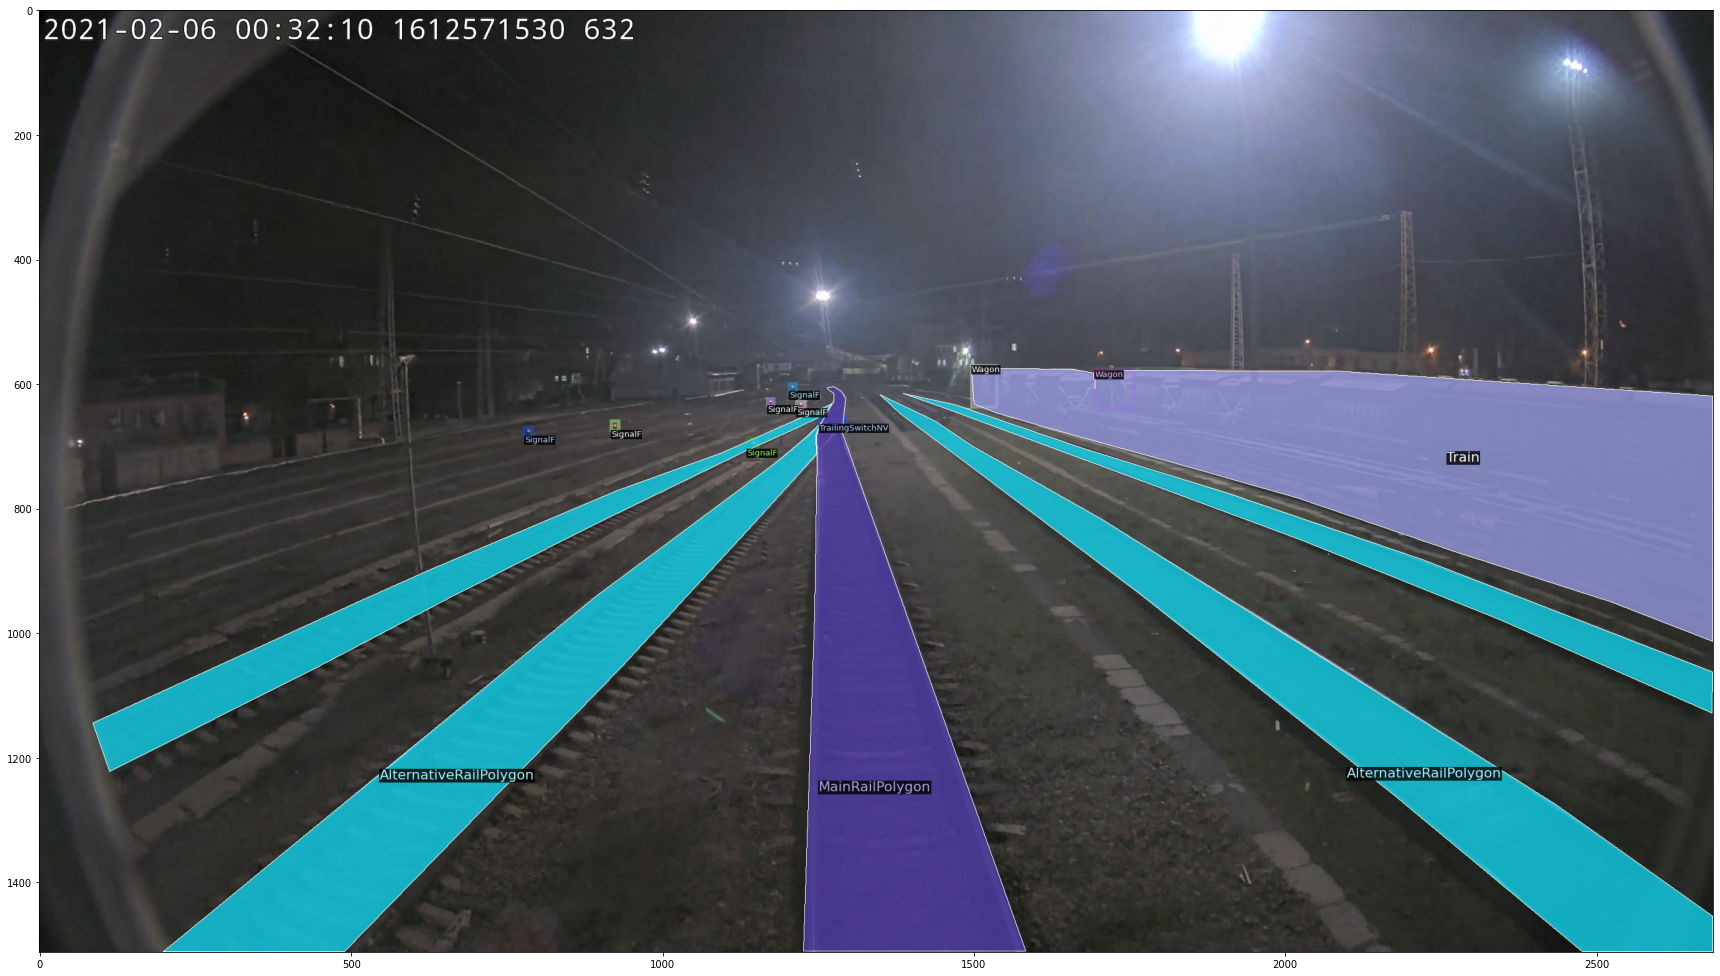

/home/user/conda/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/home/user/conda/lib/python3.7/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:154: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


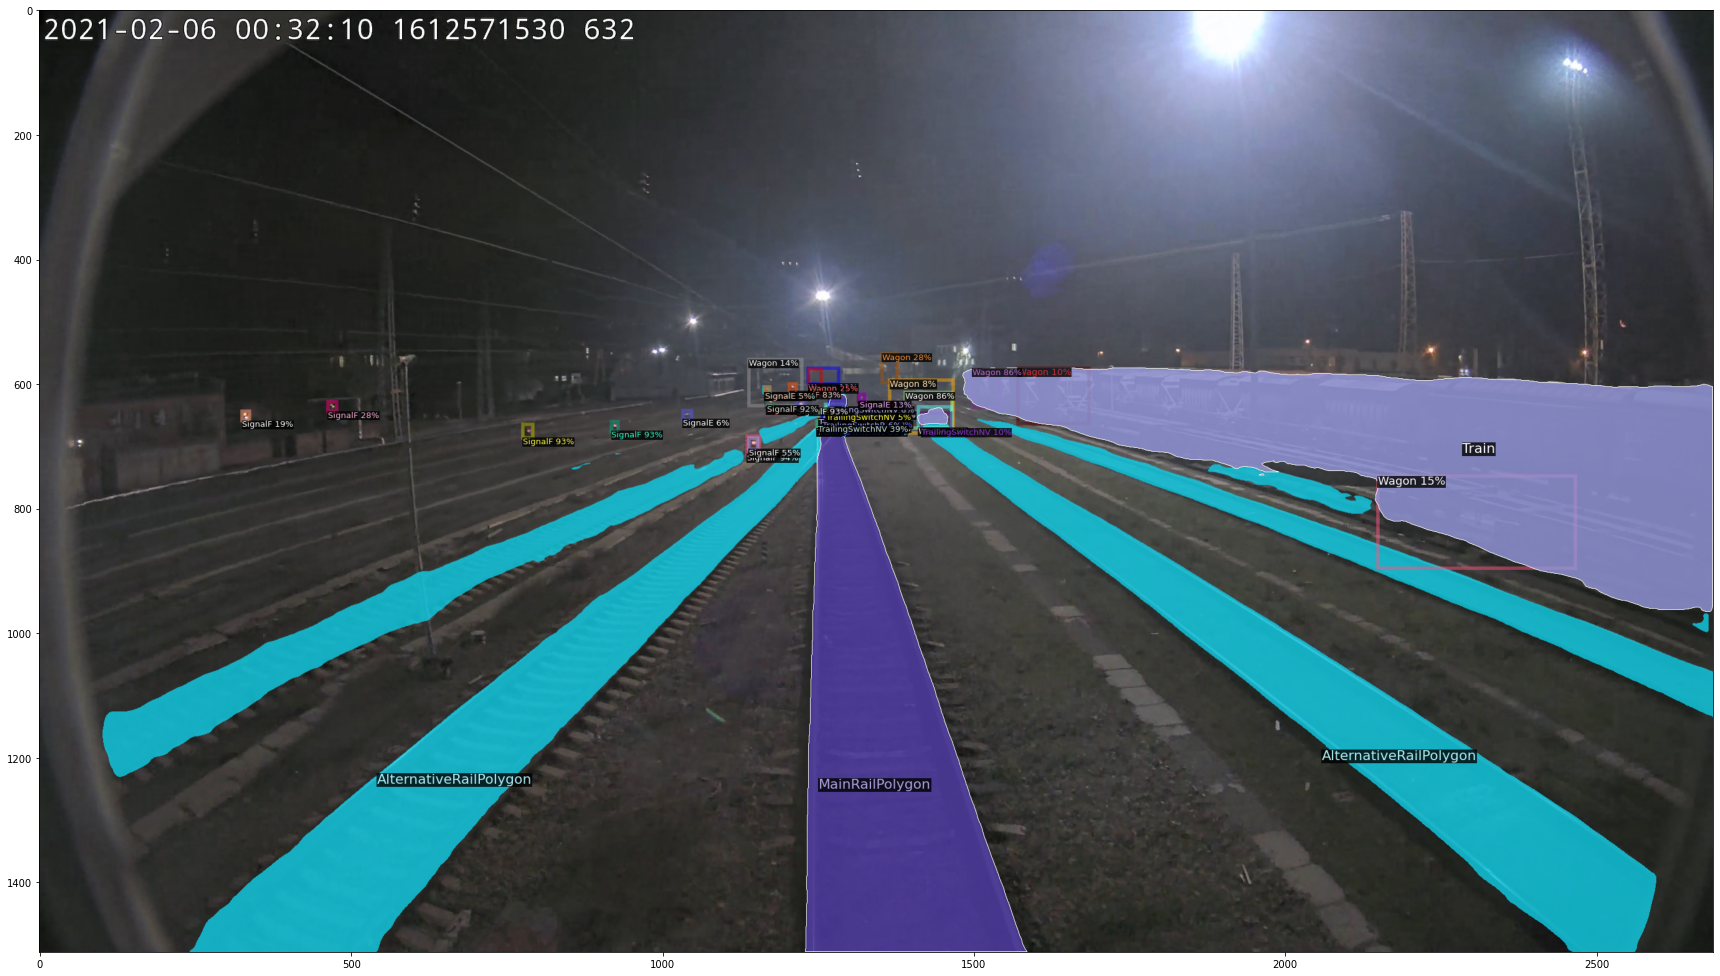

In [5]:
for d in random.sample(dataset_dicts, 1):
    _ = visualize_dataset_dict(d, metadata)
    
    im = cv2.imread(d["file_name"])
    predictions = predictor(im)
    
    instances = predictions["instances"]
    sem_seg = predictions["sem_seg"]
    sem_seg = torch.argmax(sem_seg, axis=0)
    
    preds_item = {
        "image": torch.from_numpy(im[:, :, ::-1].copy()).permute(2, 0, 1),
        "instances": instances,
        "sem_seg": sem_seg,
    }
    _ = visualize_batch_item(preds_item, metadata)